## Line Curvature Detection

In this section I shall use the sliding window approach to detect line curvature.

### Initialisation and previous work

In [11]:
# Set the right working folder to root folder of the project
import os

print("Looking for root folder of the project...")
for folder_depth in range(100): 
    if os.path.exists(".git"):
        root_folder = os.getcwd()
        print("Root folder found. Now working in directory '%s'" % os.getcwd())
        break
    else:
        print("Going up from '%s'" % os.getcwd())
        os.chdir("..")
else:
    raise Exception("Root folder of the project not found. Terminating.")
    

Looking for root folder of the project...
Root folder found. Now working in directory 'D:\Linas\projects\CarND-Advanced-Lane-Lines'


In [12]:
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import numpy as np
from math import ceil


class Plotter:
    def __init__(self, columns, figsize=(20, 40)):
        plt.figure(figsize=figsize)
        
        self.columns = columns
        self.images = []
        self.extra_plots = []
        
    def add_img(self, img, title):
        assert len(img.shape) == 2 or img.shape[2] == 3
        
        cmap = None
        if len(img.shape) == 2:
            cmap = "gray"

        self.images.append((img, title, cmap))
        self.extra_plots.append([])
        
    def add_extra_to_last_img(self, xs, ys, plot_type):
        assert plot_type in ["line"]
        self.extra_plots[-1].append((xs, ys, plot_type))
            
    def plot(self):
        j = 1  # Current column
        i = 0
        rows = ceil(len(self.images) // self.columns)
        for img_index, (img, title, cmap) in enumerate(self.images):
            # Draw iamge
            ax = plt.subplot((rows / self.columns + 1) * self.columns, self.columns, i * self.columns + j)
            ax.set_title(title)
            
            # Draw Extras
            for xs, ys, plot_type in self.extra_plots[img_index]:
                if plot_type == "line":
                    plt.plot(xs, ys, color='yellow')
            
            # Show
            plt.imshow(img, cmap="gray")
            
            if j % self.columns == 0:
                j = 0
                i += 1
            j += 1


In [13]:
def apply_precomputed_undistortion(img, mtx_filename, dist_filename):
    mtx = np.load(mtx_filename)
    dist = np.load(dist_filename)
    undist_img = cv2.undistort(img, mtx, dist)
    return undist_img


def threshold_image(img):
    # Saturation-based thresholding
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls_img[:, :, 2]
    
    s_thresh_value = 150
    s_thresh = np.zeros_like(s_channel)
    s_thresh[s_channel > s_thresh_value] = 1
    
    # Edge Detection
    red = img[:, :, 0]
    sobel_kernel = 25
    assert sobel_kernel >= 3 and sobel_kernel % 2 == 1
    sobel_x = cv2.Sobel(red, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(red, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    sobel_x = np.absolute(sobel_x)
    sobel_y = np.absolute(sobel_y)

    # Magnitude
    magnitude = (sobel_x**2 + sobel_y**2)**.5
    mag_norm = np.uint8(255 * magnitude / np.max(magnitude))
    mag_thresh_value = 30
    mag_thresh = np.zeros_like(mag_norm, dtype=np.uint8)
    mag_thresh[mag_norm > mag_thresh_value] = 1
    
    # Direction
    atan = np.arctan2(sobel_y, sobel_x)
    atan_thresh_min = 0.8
    atan_thresh_max = 1.2
    dir_thresh = np.zeros_like(atan, dtype=np.uint8)
    dir_thresh[(atan > atan_thresh_min) & (atan <= atan_thresh_max)] = 1
    
    # Combinations
    mag_and_dir = cv2.bitwise_and(mag_thresh, dir_thresh)    
    grad_or_color = cv2.bitwise_or(mag_and_dir, s_thresh)
    
    return grad_or_color


def warp_perspective(img, x_offset=200, y_offset=100, new_image_shape=(1000, 1000)):    
    # Detect Lines
    # Luckily, the camera resolution is 1280 x 720 in all iamges / videos we're given. This means I can hardode the values.
    top_left  = [578,  463]
    top_right = [706,  463]
    bot_right = [1043, 677]
    bot_left  = [267,  677]
    src_corners = np.float32([top_left, top_right, bot_right, bot_left])
    
    line_img = np.zeros(new_image_shape, dtype=np.uint8)
    
    new_top_left  = [x_offset, y_offset]
    new_top_right = [line_img.shape[1] - x_offset, y_offset]
    new_bot_right = [line_img.shape[1] - x_offset, line_img.shape[0] - y_offset]
    new_bot_left  = [x_offset, line_img.shape[0] - y_offset]
    dst_corners = np.float32([new_top_left, new_top_right, new_bot_right, new_bot_left])
    
    transform_matrix = cv2.getPerspectiveTransform(src_corners, dst_corners)
    warped = cv2.warpPerspective(img, transform_matrix, line_img.shape[::-1], flags=cv2.INTER_LINEAR)

    return warped


### Polyfit

In this section I shall fit the polynomial lines to the lane lines.

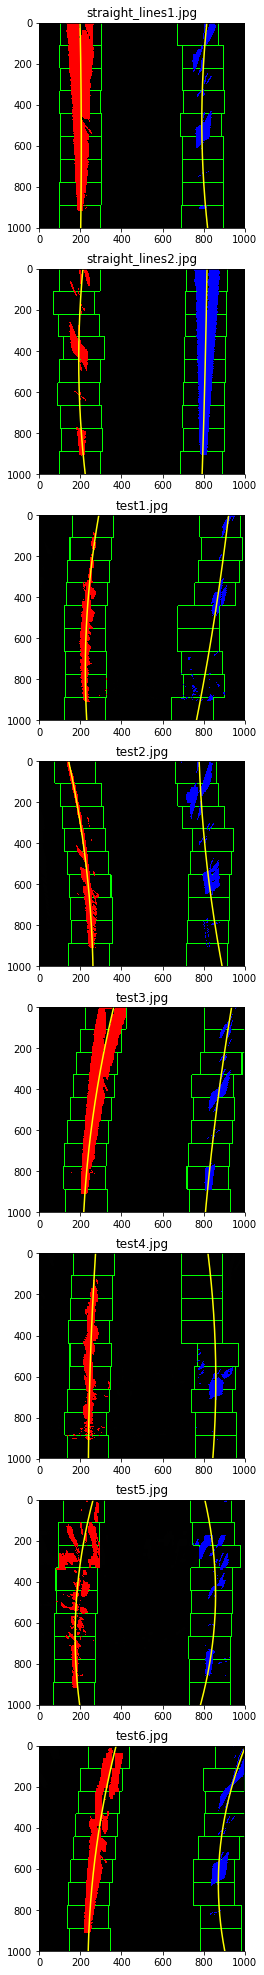

In [14]:
image_path_pattern = os.path.join(root_folder, "data", "test_images", "*.jpg")
image_fnames = glob.glob(image_path_pattern)

plotter = Plotter(columns=1, figsize=(20, 40))

for i, img_fname in enumerate(image_fnames):
    img = mpimg.imread(img_fname)
    
    # Undistort Image
    mtx_filename  = os.path.join(root_folder, "params", "camera_matrix.npy")
    dist_filename = os.path.join(root_folder, "params", "dist_coeffs.npy")
    undistorted = apply_precomputed_undistortion(img, mtx_filename, dist_filename)
    
    # Threshold image
    thresh = threshold_image(undistorted)
    
    # Focus on the road lines by warping perspective
    warped = warp_perspective(thresh, x_offset=200, y_offset=100, new_image_shape=(1000, 1000))
    
    # Find Curvature
    warped_y_midpoint = warped.shape[0] // 2
    histogram = np.sum(warped[warped_y_midpoint:, :], axis=0)
    out_img = np.dstack((warped, warped, warped))
    
    hist_x_midpoint = np.int(histogram.shape[0] // 2)
    left_x_base = np.argmax(histogram[:hist_x_midpoint])
    right_x_base = np.argmax(histogram[hist_x_midpoint:]) + hist_x_midpoint

    # Hyperparameters
    win_min_pix = 50  # minimum number of pixels found to recenter window
    win_num = 9  # the number of sliding windows
    win_half_width = 200 // 2
    win_height = np.int(warped.shape[0] // win_num)
    
    nonzero = warped.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    
    left_x_current = left_x_base
    right_x_current = right_x_base
    left_lane_inds = []
    right_lane_inds = []
    
    for win_index in range(win_num):
        win_y_low = warped.shape[0] - (win_index + 1) * win_height
        win_y_high = warped.shape[0] - win_index * win_height
        win_x_left_low   = left_x_current - win_half_width
        win_x_left_high  = left_x_current  + win_half_width
        win_x_right_low  = right_x_current - win_half_width
        win_x_right_high = right_x_current + win_half_width
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_x_left_low,  win_y_low), (win_x_left_high,  win_y_high), color=(0, 255, 0), thickness=3)
        cv2.rectangle(out_img, (win_x_right_low, win_y_low), (win_x_right_high, win_y_high), color=(0, 255, 0), thickness=3)
        
        good_left_inds = (
            (nonzero_x >= win_x_left_low) &
            (nonzero_x < win_x_left_high) &
            (nonzero_y >= win_y_low) &
            (nonzero_y < win_y_high)
        ).nonzero()[0]
        good_right_inds = (
            (nonzero_x >= win_x_right_low) &
            (nonzero_x < win_x_right_high) &
            (nonzero_y >= win_y_low) &
            (nonzero_y < win_y_high)
        ).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > win_min_pix:
            left_x_current = np.int(np.mean(nonzero_x[good_left_inds]))
        if len(good_right_inds) > win_min_pix:        
            right_x_current = np.int(np.mean(nonzero_x[good_right_inds]))

    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError as e:
        raise e

    left_x = nonzero_x[left_lane_inds]
    left_y = nonzero_y[left_lane_inds] 
    right_x = nonzero_x[right_lane_inds]
    right_y = nonzero_y[right_lane_inds]

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[left_y, left_x] = [255, 0, 0]
    out_img[right_y, right_x] = [0, 0, 255]
    
    # Polyfit
    left_fit = np.polyfit(left_y, left_x, 2)
    right_fit = np.polyfit(right_y, right_x, 2)

    # Generate x and y values for plotting
    plot_y = np.linspace(0, warped.shape[0] - 1, warped.shape[0])
    try:
        left_fit_x = left_fit[0] * plot_y**2 + left_fit[1] * plot_y + left_fit[2]
        right_fit_x = right_fit[0] * plot_y**2 + right_fit[1]*plot_y + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1 * plot_y**2 + 1 * plot_y
        right_fitx = 1 * plot_y**2 + 1 * plot_y

    plotter.add_img(out_img, os.path.basename(img_fname))
    plotter.add_extra_to_last_img(left_fit_x,  plot_y, "line")
    plotter.add_extra_to_last_img(right_fit_x, plot_y, "line")
    
plotter.plot()


### Curvature Measure

Now that I can plot plynomial lane lines, I shall measure the curvature.

In [6]:
image_path_pattern = os.path.join(root_folder, "data", "test_images", "*.jpg")
image_fnames = glob.glob(image_path_pattern)

plotter = Plotter(columns=1, figsize=(20, 40))

for i, img_fname in enumerate(image_fnames):
    img = mpimg.imread(img_fname)
    
    # Undistort Image
    mtx_filename  = os.path.join(root_folder, "params", "camera_matrix.npy")
    dist_filename = os.path.join(root_folder, "params", "dist_coeffs.npy")
    undistorted = apply_precomputed_undistortion(img, mtx_filename, dist_filename)
    
    # Threshold image
    thresh = threshold_image(undistorted)
    
    # Focus on the road lines by warping perspective
    warped = warp_perspective(thresh, x_offset=200, y_offset=100, new_image_shape=(1000, 1000))
    
    ym_per_pix = 30 / 720 # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700 # meters per pixel in x dimension
    
    # Find Curvature
    warped_y_midpoint = warped.shape[0] // 2
    histogram = np.sum(warped[warped_y_midpoint:, :], axis=0)
    out_img = np.dstack((warped, warped, warped))
    
    hist_x_midpoint = np.int(histogram.shape[0] // 2)
    left_x_base = np.argmax(histogram[:hist_x_midpoint])
    right_x_base = np.argmax(histogram[hist_x_midpoint:]) + hist_x_midpoint

    # Hyperparameters
    win_min_pix = 50  # minimum number of pixels found to recenter window
    win_num = 9  # the number of sliding windows
    win_half_width = 200 // 2
    win_height = np.int(warped.shape[0] // win_num)
    
    nonzero = warped.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    
    left_x_current = left_x_base
    right_x_current = right_x_base
    left_lane_inds = []
    right_lane_inds = []
    
    for win_index in range(win_num):
        win_y_low = warped.shape[0] - (win_index + 1) * win_height
        win_y_high = warped.shape[0] - win_index * win_height
        win_x_left_low   = left_x_current - win_half_width
        win_x_left_high  = left_x_current  + win_half_width
        win_x_right_low  = right_x_current - win_half_width
        win_x_right_high = right_x_current + win_half_width
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_x_left_low,  win_y_low), (win_x_left_high,  win_y_high), color=(0, 255, 0), thickness=3)
        cv2.rectangle(out_img, (win_x_right_low, win_y_low), (win_x_right_high, win_y_high), color=(0, 255, 0), thickness=3)
        
        good_left_inds = (
            (nonzero_x >= win_x_left_low) &
            (nonzero_x < win_x_left_high) &
            (nonzero_y >= win_y_low) &
            (nonzero_y < win_y_high)
        ).nonzero()[0]
        good_right_inds = (
            (nonzero_x >= win_x_right_low) &
            (nonzero_x < win_x_right_high) &
            (nonzero_y >= win_y_low) &
            (nonzero_y < win_y_high)
        ).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > win_min_pix:
            left_x_current = np.int(np.mean(nonzero_x[good_left_inds]))
        if len(good_right_inds) > win_min_pix:        
            right_x_current = np.int(np.mean(nonzero_x[good_right_inds]))

    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError as e:
        raise e

    left_x = nonzero_x[left_lane_inds]
    left_y = nonzero_y[left_lane_inds] 
    right_x = nonzero_x[right_lane_inds]
    right_y = nonzero_y[right_lane_inds]

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[left_y, left_x] = [255, 0, 0]
    out_img[right_y, right_x] = [0, 0, 255]
    
    # Polyfit    
    left_fit = np.polyfit(left_y,   left_x, 2)
    right_fit = np.polyfit(right_y, right_x, 2)
    real_left_fit = np.polyfit(left_y * ym_per_pix,   left_x * xm_per_pix, 2)
    real_right_fit = np.polyfit(right_y * ym_per_pix, right_x * xm_per_pix, 2)

    # Generate x and y values for plotting
    plot_y = np.linspace(0, warped.shape[0] - 1, warped.shape[0])
    try:
        left_fit_x = left_fit[0] * plot_y**2 + left_fit[1] * plot_y + left_fit[2]
        right_fit_x = right_fit[0] * plot_y**2 + right_fit[1]*plot_y + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1 * plot_y**2 + 1 * plot_y
        right_fitx = 1 * plot_y**2 + 1 * plot_y
        
    plotter.add_img(out_img, os.path.basename(img_fname))
    plotter.add_extra_to_last_img(left_fit_x,  plot_y, "line")
    plotter.add_extra_to_last_img(right_fit_x, plot_y, "line")
    
    # Measure curvature    
    y_eval = np.max(plot_y)
    real_y_eval = np.max(plot_y) * ym_per_pix
    
    left_curve_rad  = (1 + (2 * left_fit[0]  * y_eval + left_fit[1])**2)**(3 / 2) / np.absolute(2 * left_fit[0])
    right_curve_rad = (1 + (2 * right_fit[0] * y_eval + right_fit[1])**2)**(3 / 2) / np.absolute(2 * right_fit[0])
    
    print(os.path.basename(img_fname), left_curve_rad, right_curve_rad)
    
plotter.plot()


NameError: name 'apply_precomputed_undistortion' is not defined

### Application

Here's the resulting polyline retrieval function

In [85]:
def retrieve_polylines(warped):    
    """
    Takes in the warped thresholds to find polylines on the road
    """
    
    # Find Curvature
    warped_y_midpoint = warped.shape[0] // 2
    histogram = np.sum(warped[warped_y_midpoint:, :], axis=0)
    out_img = np.dstack((warped, warped, warped))
    
    hist_x_midpoint = np.int(histogram.shape[0] // 2)
    left_x_base = np.argmax(histogram[:hist_x_midpoint])
    right_x_base = np.argmax(histogram[hist_x_midpoint:]) + hist_x_midpoint

    # Hyperparameters
    win_min_pix = 50  # minimum number of pixels found to recenter window
    win_num = 9  # the number of sliding windows
    win_half_width = 200 // 2
    win_height = np.int(warped.shape[0] // win_num)
    
    nonzero = warped.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    
    left_x_current = left_x_base
    right_x_current = right_x_base
    left_lane_inds = []
    right_lane_inds = []
    
    for win_index in range(win_num):
        win_y_low = warped.shape[0] - (win_index + 1) * win_height
        win_y_high = warped.shape[0] - win_index * win_height
        win_x_left_low   = left_x_current - win_half_width
        win_x_left_high  = left_x_current  + win_half_width
        win_x_right_low  = right_x_current - win_half_width
        win_x_right_high = right_x_current + win_half_width
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_x_left_low,  win_y_low), (win_x_left_high,  win_y_high), color=(0, 255, 0), thickness=3)
        cv2.rectangle(out_img, (win_x_right_low, win_y_low), (win_x_right_high, win_y_high), color=(0, 255, 0), thickness=3)
        
        good_left_inds = (
            (nonzero_x >= win_x_left_low) &
            (nonzero_x < win_x_left_high) &
            (nonzero_y >= win_y_low) &
            (nonzero_y < win_y_high)
        ).nonzero()[0]
        good_right_inds = (
            (nonzero_x >= win_x_right_low) &
            (nonzero_x < win_x_right_high) &
            (nonzero_y >= win_y_low) &
            (nonzero_y < win_y_high)
        ).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > win_min_pix:
            left_x_current = np.int(np.mean(nonzero_x[good_left_inds]))
        if len(good_right_inds) > win_min_pix:        
            right_x_current = np.int(np.mean(nonzero_x[good_right_inds]))

    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError as e:
        raise e

    left_x = nonzero_x[left_lane_inds]
    left_y = nonzero_y[left_lane_inds] 
    right_x = nonzero_x[right_lane_inds]
    right_y = nonzero_y[right_lane_inds]
    
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[left_y, left_x] = [255, 0, 0]
    out_img[right_y, right_x] = [0, 0, 255]
    
    # Polyfit
    left_fit = np.polyfit(left_y, left_x, 2)
    right_fit = np.polyfit(right_y, right_x, 2)

    return out_img, left_fit, right_fit

def retrieve_polylines(warped, left_fit, right_fit):
    """
    The same polyfit function, but this time it uses the window around previous polynomial lines to search for pixels.
    """
    # Hyperparameters
    win_half_width = 200 // 2

    nonzero = warped.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])

    left_lane_inds = (
        (nonzero_x > (left_fit[0] * (nonzero_y**2) + left_fit[1] * nonzero_y + left_fit[2] - win_half_width)) &
        (nonzero_x < (left_fit[0] * (nonzero_y**2) + left_fit[1] * nonzero_y + left_fit[2] + win_half_width))
    )
    right_lane_inds = (
        (nonzero_x > (right_fit[0]*(nonzero_y**2) + right_fit[1] * nonzero_y + right_fit[2] - win_half_width)) &
        (nonzero_x < (right_fit[0]*(nonzero_y**2) + right_fit[1] * nonzero_y + right_fit[2] + win_half_width))
    )

    left_x = nonzero_x[left_lane_inds]
    left_y = nonzero_y[left_lane_inds] 
    right_x = nonzero_x[right_lane_inds]
    right_y = nonzero_y[right_lane_inds]

    left_fit = np.polyfit(left_y, left_x, 2)
    right_fit = np.polyfit(right_y, right_x, 2)
    plot_y = np.linspace(0, warped.shape[0] - 1, warped.shape[0])
    
    out_img = np.dstack((warped, warped, warped)) * 255
    win_img = np.zeros_like(out_img)

    out_img[nonzero_y[left_lane_inds],  nonzero_x[left_lane_inds]]  = [255, 0, 0]
    out_img[nonzero_y[right_lane_inds], nonzero_x[right_lane_inds]] = [0, 0, 255]

    left_line_window_1 = np.array([
        np.vstack([left_fitx - win_half_width, ploty]).T
    ])
    left_line_window_2 = np.array([
        np.flipud(np.vstack([left_fitx + win_half_width, ploty]).T)
    ])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    right_line_window1 = np.array([
        np.vstack([right_fitx-win_half_width, ploty]).T
    ])
    right_line_window2 = np.array([
        np.flipud(np.vstack([right_fitx + win_half_width, ploty]).T)
    ])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    cv2.fillPoly(win_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(win_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, win_img, 0.3, 0)
    
    return result, left_fit, right_fit

def generate_polyline_plots(warped_shape, left_fit, right_fit):
    # Generate x and y values for plotting
    plot_y = np.linspace(0, warped_shape[0] - 1, warped_shape[0])

    left_fit_x = left_fit[0] * plot_y**2 + left_fit[1] * plot_y + left_fit[2]
    right_fit_x = right_fit[0] * plot_y**2 + right_fit[1] * plot_y + right_fit[2]

    # # Now call:
    # plotter.add_img(out_img, "warped image")
    # plotter.add_extra_to_last_img(left_fit_x,  plot_y, "line")
    # plotter.add_extra_to_last_img(right_fit_x, plot_y, "line")
    
    return left_fit_x, right_fit_x, plot_y
    

def process_img(img):
    """
    The preprocessing function, containingcurrent and all previously developed steps
    """
    mtx_filename  = os.path.join(root_folder, "params", "camera_matrix.npy")
    dist_filename = os.path.join(root_folder, "params", "dist_coeffs.npy")
    undistorted = apply_precomputed_undistortion(img, mtx_filename, dist_filename)
    
    thresh = threshold_image(undistorted)
    
    warped = warp_perspective(thresh, x_offset=200, y_offset=100, new_image_shape=(1000, 1000))
    
    out_img, left_fit, right_fit = retrieve_polylines(warped)
    
    return out_img